<a href="https://colab.research.google.com/github/CBA107048/Project/blob/main/maze_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 匯入套件
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

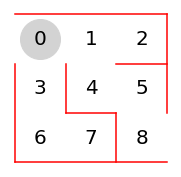

In [ ]:
# 製作迷宮
fig = plt.figure(figsize=(3, 3))

# 製作銅牆鐵壁
plt.plot([0, 3], [3, 3], color='r')
plt.plot([0, 3], [0, 0], color='r')
plt.plot([0, 0], [0, 2], color='r')
plt.plot([3, 3], [1, 3], color='r')
plt.plot([1, 1], [1, 2], color='r')
plt.plot([2, 3], [2, 2], color='r')
plt.plot([2, 1], [1, 1], color='r')
plt.plot([2, 2], [0, 1], color='r')

# 製作編號位置 0、1、2、3、4 ...
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 製作當前位置的灰色圓圈，代理人之位置
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 隱藏繪圖區的邊框
plt.tick_params(axis='both', which='both', bottom = False, top= False,
        labelbottom=False, right=False, left=False, labelleft=False)
plt.box(False)

In [ ]:
# 準備參數 θ
#[上,右,下,左]
theta_0 = np.array([
    [np.nan, 1, 1, np.nan],          # 第 0 格
    [np.nan, 1, 1, 1],               # 第 1 格
    [np.nan, np.nan, np.nan, 1],     # 第 2 格
    [1, np.nan, 1, np.nan],          # 第 3 格
    [1, 1, np.nan, np.nan],          # 第 4 格
    [np.nan, np.nan, 1, 1],          # 第 5 格
    [1, 1, np.nan, np.nan],          # 第 6 格
    [np.nan, np.nan, np.nan, 1]])    # 第 7 格

# 定義get_pi()函式
def get_pi(theta):
    # 利用 softmax 進行轉換
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    pi = np.nan_to_num(pi)    
    return pi

# 將參數 θ 轉換成機率的形式
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [ ]:
# 設定初始的動作價值函數表 （Q-table）

[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.1 # 乘theta_0是為了使牆方向的值為nan

In [ ]:
print(Q)

[[       nan 0.09892545 0.04889674        nan]
 [       nan 0.0007582  0.07718521 0.03286806]
 [       nan        nan        nan 0.05064076]
 [0.09708426        nan 0.05760263        nan]
 [0.07075036 0.06307584        nan        nan]
 [       nan        nan 0.06815269 0.09631067]
 [0.06175065 0.01629888        nan        nan]
 [       nan        nan        nan 0.06046292]]


In [ ]:
# 設定初始的動作價值函數表
#[a, b] = theta_0.shape
#Q = np.random.rand(a, b) * theta_0 * 1
#print(Q)

In [ ]:
# 根據動作取得下一個狀態(位置)
def get_s_next(s, a):
    if a == 0: # 上
        return s - 3
    elif a == 2: # 下
        return s + 3
    elif a == 3: # 左
        return s - 1
    elif a == 1: # 右
        return s + 1
   
  

In [ ]:
# 隨機或根據動作價值函數式選擇動作
def get_a(s, Q, epsilon, pi_0):
    if np.random.rand() < epsilon:
        # 依機率分布隨機選擇動作
        return np.random.choice([0, 1, 2, 3], p=pi_0[s])
    else:
        # 根據動作價值函數式選擇動作
        return np.nanargmax(Q[s])

In [ ]:
# 利用 Q Learning更新動作價值函式
#def q_learning(s, a, r, s_next, a_next, Q):
 #   eta = 0.1 # 學習率
  #  gamma = 0.9 # 時間折扣率
    
   # if s_next == 8:
    #    Q[s, a] = Q[s, a] + eta * (r - Q[s, a]) #已經抵達終點，所以沒有下一步
    #else:
     #   Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a]) #Q-learning演算法
    #return Q

In [ ]:
# 利用 Sarsa 演算法更新動作價值函式
def sarsa(s, a, r, s_next, a_next, Q):
    eta = 0.1 # 學習率
    gamma = 0.9 # 時間折扣率
    
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])#已經抵達終點，所以沒有下一步
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a]) #Sarsa 演算法
    return Q

In [ ]:
# 執行1回合
def play(Q, epsilon, pi):
    s = 0 # 狀態
    a = a_next = get_a(s, Q, epsilon, pi) # 下一步的動作
    s_a_history = [[0, np.nan]] # 狀態與動作的歷程資料

    # 持續循環直到回合結束
    while True:
        # 根據動作取得下一個狀態
        a = a_next
        s_next = get_s_next(s, a)

        # 更新歷程資料
        s_a_history[-1][1] = a
        s_a_history.append([s_next, np.nan])

        # 判斷是否結束
        if s_next == 8:
            r = 1 #回饋值；獎勵 1
            a_next = np.nan
        else:
            r = 0 #回饋值；獎勵 0，沒有
            
            # 根據動作價值函數取得動作
            a_next = get_a(s_next, Q, epsilon, pi)

        Q = sarsa(s, a, r, s_next, a_next, Q)
        #Q = q_learning(s, a, r, s_next, a_next, Q)

        # 判斷是否結束
        if s_next == 8:
            break
        else:
            s = s_next

    # 回傳歷史資料及動作價值函數式
    return [s_a_history, Q]

In [ ]:
# Train (Sarsa)
epsilon = 0.5  # ε的初始值(ε-greedy)

# 利用迴圈進行訓練
for episode in range(10): #設定訓練10回合
    # 逐漸縮小 ε 的值
    epsilon = epsilon / 2 #逐漸縮小 ε 的值

    # 執行1回合並取得歷史資料與動作價值函數
    [s_a_history, Q] = play(Q, epsilon, pi_0)
    
    print('回合: {}, 步數: {}'.format(episode, len(s_a_history)-1))

回合: 0, 步數: 58
回合: 1, 步數: 4
回合: 2, 步數: 4
回合: 3, 步數: 4
回合: 4, 步數: 4
回合: 5, 步數: 4
回合: 6, 步數: 4
回合: 7, 步數: 4
回合: 8, 步數: 4
回合: 9, 步數: 4


In [ ]:
# 用來更新動畫的函式
def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state / 3))
    return circle

# 動畫製作
anim = animation.FuncAnimation(fig, animate, \
        frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())


6 x 6 Maze

回合数：1
0.2160478445990421
求解迷宫步數 98
回合数：2
0.32872989175199196
求解迷宫步數 554
回合数：3
0.16259628470685625
求解迷宫步數 218
回合数：4
0.21358446296384456
求解迷宫步數 340
回合数：5
0.17629876968553587
求解迷宫步數 484
回合数：6
0.11267303342007423
求解迷宫步數 84
回合数：7
0.0912540959328502
求解迷宫步數 12
回合数：8
0.0897864721855686
求解迷宫步數 10
回合数：9
0.08862069805160644
求解迷宫步數 10
回合数：10
0.08745860738326992
求解迷宫步數 10
回合数：11
0.0863042564983672
求解迷宫步數 10
回合数：12
0.08516003646766084
求解迷宫步數 10
回合数：13
0.08402679207370203
求解迷宫步數 10
回合数：14
0.08297223668563157
求解迷宫步數 10
回合数：15
0.08198323361350351
求解迷宫步數 10
回合数：16
0.08101565008936963
求解迷宫步數 10
回合数：17
0.08015094354668165
求解迷宫步數 10
回合数：18
0.07927566190804683
求解迷宫步數 10
回合数：19
0.0783908538463875
求解迷宫步數 10
回合数：20
0.07749695373248142
求解迷宫步數 10
回合数：21
0.07659384833435562
求解迷宫步數 10
回合数：22
0.07568095007537629
求解迷宫步數 10
回合数：23
0.07475727489424601
求解迷宫步數 10
回合数：24
0.07389030597086596
求解迷宫步數 10
回合数：25
0.07311537923823187
求解迷宫步數 10
回合数：26
0.07233715388397127
求解迷宫步數 10
回合数：27
0.0715553941455433
求解迷宫步數 10
回合数：28
0.070

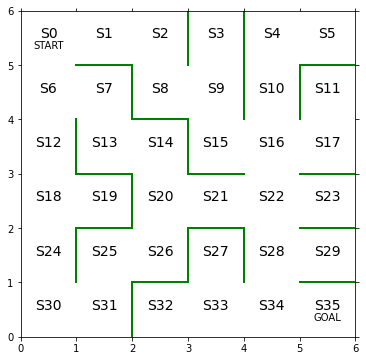

In [ ]:
# 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm
%matplotlib inline

# 迷宫的初始位置

# 
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

# 红色Wall
plt.plot([1, 1], [4, 3], color='g', linewidth=2)
plt.plot([1, 2], [3, 3], color='g', linewidth=2)
plt.plot([2, 2], [3, 2], color='g', linewidth=2)
plt.plot([1, 2], [2, 2], color='g', linewidth=2)
plt.plot([1, 1], [2, 1], color='g', linewidth=2)

plt.plot([1, 2], [5, 5], color='g', linewidth=2)
plt.plot([2, 2], [5, 4], color='g', linewidth=2)
plt.plot([2, 3], [4, 4], color='g', linewidth=2)
plt.plot([3, 3], [4, 3], color='g', linewidth=2)
plt.plot([3, 4], [3, 3], color='g', linewidth=2)

plt.plot([2, 2], [1, 0], color='g', linewidth=2)
plt.plot([2, 3], [1, 1], color='g', linewidth=2)
plt.plot([3, 3], [1, 2], color='g', linewidth=2)
plt.plot([3, 4], [2, 2], color='g', linewidth=2)
plt.plot([4, 4], [2, 1], color='g', linewidth=2)

plt.plot([3, 3], [6, 5], color='g', linewidth=2)

plt.plot([4, 4], [6, 4], color='g', linewidth=2)

plt.plot([5, 5], [5, 4], color='g', linewidth=2)
plt.plot([5, 6], [5, 5], color='g', linewidth=2)

plt.plot([5, 6], [3, 3], color='g', linewidth=2)
plt.plot([5, 6], [2, 2], color='g', linewidth=2)
plt.plot([5, 6], [1, 1], color='g', linewidth=2)

# 畫出文字S0-S35
s = 0
for i in range(0, 6):
    for j in range(0, 6):
        plt.text(0.5 + j, 5.5 - i, 'S'+str(s), size=14, ha='center')
        s += 1

plt.text(0.5, 5.3, 'START', ha='center')
plt.text(5.5, 0.3, 'GOAL', ha='center')

# 
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 
line, = ax.plot([0.5], [5.5], marker='o', color='g', markersize=40)

# 

# 行為行為 state 0-34
theta_0 = np.array([
    [np.nan, 1, 1, np.nan],  # S0
    [np.nan, 1, np.nan, 1],  # S1
    [np.nan, np.nan, 1, 1],  # S2
    [np.nan, np.nan, 1, np.nan],       # S3
    [np.nan, 1, 1, np.nan],  # S4
    [np.nan, np.nan, np.nan, 1],    # S5

    [1, 1, 1, np.nan],  # S6
    [np.nan, np.nan, 1, 1],  # S7
    [1, 1, np.nan, np.nan],  # S8
    [1, np.nan, 1, 1],       # S9
    [1, np.nan, 1, np.nan],  # S10
    [np.nan, np.nan, 1, np.nan],    # S11

    [1, np.nan, 1, np.nan],  # S12
    [1, 1, np.nan, np.nan],  # S13
    [np.nan, np.nan, 1, 1],  # S14
    [1, 1, np.nan, np.nan],       # S15
    [1, 1, 1, 1],  # S16
    [1, np.nan, np.nan, 1],    # S17

    [1, 1, 1, np.nan],  # S18
    [np.nan, np.nan, np.nan, 1],  # S19
    [1, 1, 1, np.nan],  # S20
    [np.nan, 1, np.nan, 1],       # S21
    [1, 1, 1, 1],  # S22
    [np.nan, np.nan, np.nan, 1],    # S23

    [1, np.nan, 1, np.nan],  # S24
    [np.nan, 1, 1, np.nan],  # S25
    [1, np.nan, np.nan, 1],  # S26
    [np.nan, np.nan, 1, np.nan],       # S27
    [1, 1, 1, np.nan],  # S28
    [np.nan, np.nan, np.nan, 1],    # S29

    [1, 1, np.nan, np.nan],  # S30
    [1, np.nan, np.nan, 1],  # S31
    [np.nan, 1, np.nan, np.nan],  # S32
    [1, 1, np.nan, 1],       # S33
    [1, 1, np.nan, 1],  # S34
    # [1, np.nan, np.nan, np.nan],    # S35
])

# 

[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.1 # 

# 

def simple_convert_into_pi_from_theta(theta):
    ''' Vslew '''
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

# 
pi_0 = simple_convert_into_pi_from_theta(theta_0)

# 
def get_action(s, Q, epsilon, pi_0):
    direction = ['up', 'right', 'down', 'left']

    # 
    if np.random.rand() < epsilon:
        # 
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # 
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 
    if next_direction == 'up':
        action = 0
    elif next_direction == 'right':
        action = 1
    elif next_direction == 'down':
        action = 2
    elif next_direction == 'left':
        action = 3
    return action

def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ['up', 'right', 'down', 'left']
    next_direction = direction[a]

    # 
    if next_direction == 'up':
        s_next = s - 6
    elif next_direction == 'right':
        s_next = s + 1
    elif next_direction == 'down':
        s_next = s + 6
    elif next_direction == 'left':
        s_next = s - 1

    return s_next

# 
#def Q_learning(s, a, r, s_next, Q, eta, gamma):
#    if s_next == 35:
#        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
#    else:
#        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])

#    return Q

# 利用 Sarsa 演算法更新動作價值函式
def sarsa(s, a, r, s_next, a_next, Q):
    eta = 0.1 # 學習率
    gamma = 0.9 # 時間折扣率
    
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])#已經抵達終點，所以沒有下一步
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a]) #Sarsa 演算法
    return Q
# 
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi) # 初始
    s_a_history = [[0, np.nan]] # 

    while (1):
        a = a_next # 更新

        # 
        s_a_history[-1][1] = a  

        # 
        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 
        s_a_history.append([s_next, np.nan])

        if s_next == 35:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        if s_next == 35:
            break
        else:
            s = s_next
    return [s_a_history, Q]

eta = 0.1       # 
gamma = 0.9     # 
epsilon = 0.5   # 
v = np.nanmax(Q, axis=1) # 
is_continue = True
episode = 1

V = [] # 
V.append(np.nanmax(Q, axis=1))

while is_continue:
    print('回合数：'+str(episode))

    # 
    epsilon = epsilon / 2

    # 
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v)))
    v = new_v
    V.append(v)

    print('求解迷宫步數 '+str(len(s_a_history) - 1))

    # 走100回合
    episode = episode + 1
    if episode > 100:
        break
print(Q)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    ''' 每一畫面内容 '''
    state = s_a_history[i][0]
    x = (state % 6) + 0.5
    y = 5.5 - int(state / 6)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=100, repeat=False)
HTML(anim.to_jshtml())



回合数：1
0.7233576327271516
求解迷宫步數 792
回合数：2
0.10425453176834627
求解迷宫步數 24
回合数：3
0.11006494349382401
求解迷宫步數 40
回合数：4
0.18791221670759195
求解迷宫步數 270
回合数：5
0.09447827588962752
求解迷宫步數 18
回合数：6
0.10287819163658052
求解迷宫步數 34
回合数：7
0.09595819157055574
求解迷宫步數 20
回合数：8
0.09325153799168465
求解迷宫步數 22
回合数：9
0.09434483315200658
求解迷宫步數 22
回合数：10
0.09279942797031676
求解迷宫步數 20
回合数：11
0.09029635526581348
求解迷宫步數 24
回合数：12
0.0891501849833743
求解迷宫步數 22
回合数：13
0.09171229183090411
求解迷宫步數 30
回合数：14
0.08806313982207903
求解迷宫步數 22
回合数：15
0.08773052344290033
求解迷宫步數 28
回合数：16
0.08553638358897747
求解迷宫步數 24
回合数：17
0.08359867886821909
求解迷宫步數 24
回合数：18
0.08555091998574238
求解迷宫步數 24
回合数：19
0.08070765978137348
求解迷宫步數 20
回合数：20
0.08197231588410231
求解迷宫步數 26
回合数：21
0.07966505965860005
求解迷宫步數 22
回合数：22
0.08042211113165171
求解迷宫步數 24
回合数：23
0.07836331185070669
求解迷宫步數 22
回合数：24
0.0764460476975516
求解迷宫步數 20
回合数：25
0.07769302689602936
求解迷宫步數 26
回合数：26
0.07692071698455621
求解迷宫步數 22
回合数：27
0.07408550192219723
求解迷宫步數 20
回合数：28
0.07

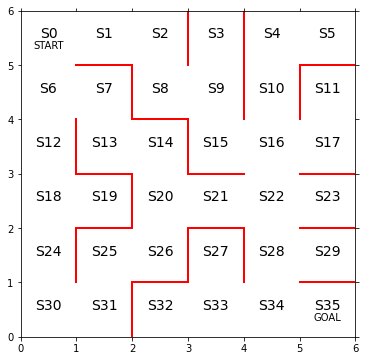

In [ ]:
# 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm
%matplotlib inline

# 迷宫的初始位置

# 
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

# 红色Wall
plt.plot([1, 1], [4, 3], color='r', linewidth=2)
plt.plot([1, 2], [3, 3], color='r', linewidth=2)
plt.plot([2, 2], [3, 2], color='r', linewidth=2)
plt.plot([1, 2], [2, 2], color='r', linewidth=2)
plt.plot([1, 1], [2, 1], color='r', linewidth=2)

plt.plot([1, 2], [5, 5], color='r', linewidth=2)
plt.plot([2, 2], [5, 4], color='r', linewidth=2)
plt.plot([2, 3], [4, 4], color='r', linewidth=2)
plt.plot([3, 3], [4, 3], color='r', linewidth=2)
plt.plot([3, 4], [3, 3], color='r', linewidth=2)

plt.plot([2, 2], [1, 0], color='r', linewidth=2)
plt.plot([2, 3], [1, 1], color='r', linewidth=2)
plt.plot([3, 3], [1, 2], color='r', linewidth=2)
plt.plot([3, 4], [2, 2], color='r', linewidth=2)
plt.plot([4, 4], [2, 1], color='r', linewidth=2)

plt.plot([3, 3], [6, 5], color='r', linewidth=2)

plt.plot([4, 4], [6, 4], color='r', linewidth=2)

plt.plot([5, 5], [5, 4], color='r', linewidth=2)
plt.plot([5, 6], [5, 5], color='r', linewidth=2)

plt.plot([5, 6], [3, 3], color='r', linewidth=2)
plt.plot([5, 6], [2, 2], color='r', linewidth=2)
plt.plot([5, 6], [1, 1], color='r', linewidth=2)

# 畫出文字S0-S35
s = 0
for i in range(0, 6):
    for j in range(0, 6):
        plt.text(0.5 + j, 5.5 - i, 'S'+str(s), size=14, ha='center')
        s += 1

plt.text(0.5, 5.3, 'START', ha='center')
plt.text(5.5, 0.3, 'GOAL', ha='center')

# 
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 
line, = ax.plot([0.5], [5.5], marker='o', color='g', markersize=40)

# 

# 行為行為 state 0-34
theta_0 = np.array([
    [np.nan, 1, 1, np.nan],  # S0
    [np.nan, 1, np.nan, 1],  # S1
    [np.nan, np.nan, 1, 1],  # S2
    [np.nan, np.nan, 1, np.nan],       # S3
    [np.nan, 1, 1, np.nan],  # S4
    [np.nan, np.nan, np.nan, 1],    # S5

    [1, 1, 1, np.nan],  # S6
    [np.nan, np.nan, 1, 1],  # S7
    [1, 1, np.nan, np.nan],  # S8
    [1, np.nan, 1, 1],       # S9
    [1, np.nan, 1, np.nan],  # S10
    [np.nan, np.nan, 1, np.nan],    # S11

    [1, np.nan, 1, np.nan],  # S12
    [1, 1, np.nan, np.nan],  # S13
    [np.nan, np.nan, 1, 1],  # S14
    [1, 1, np.nan, np.nan],       # S15
    [1, 1, 1, 1],  # S16
    [1, np.nan, np.nan, 1],    # S17

    [1, 1, 1, np.nan],  # S18
    [np.nan, np.nan, np.nan, 1],  # S19
    [1, 1, 1, np.nan],  # S20
    [np.nan, 1, np.nan, 1],       # S21
    [1, 1, 1, 1],  # S22
    [np.nan, np.nan, np.nan, 1],    # S23

    [1, np.nan, 1, np.nan],  # S24
    [np.nan, 1, 1, np.nan],  # S25
    [1, np.nan, np.nan, 1],  # S26
    [np.nan, np.nan, 1, np.nan],       # S27
    [1, 1, 1, np.nan],  # S28
    [np.nan, np.nan, np.nan, 1],    # S29

    [1, 1, np.nan, np.nan],  # S30
    [1, np.nan, np.nan, 1],  # S31
    [np.nan, 1, np.nan, np.nan],  # S32
    [1, 1, np.nan, 1],       # S33
    [1, 1, np.nan, 1],  # S34
    # [1, np.nan, np.nan, np.nan],    # S35
])

# 

[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.1 # 

# 

def simple_convert_into_pi_from_theta(theta):
    ''' Vslew '''
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

# 
pi_0 = simple_convert_into_pi_from_theta(theta_0)

# 
def get_action(s, Q, epsilon, pi_0):
    direction = ['up', 'right', 'down', 'left']

    # 
    if np.random.rand() < epsilon:
        # 
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # 
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 
    if next_direction == 'up':
        action = 0
    elif next_direction == 'right':
        action = 1
    elif next_direction == 'down':
        action = 2
    elif next_direction == 'left':
        action = 3
    return action

def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ['up', 'right', 'down', 'left']
    next_direction = direction[a]

    # 
    if next_direction == 'up':
        s_next = s - 6
    elif next_direction == 'right':
        s_next = s + 1
    elif next_direction == 'down':
        s_next = s + 6
    elif next_direction == 'left':
        s_next = s - 1

    return s_next

# 
def Q_learning(s, a, r, s_next, Q, eta, gamma):
    if s_next == 35:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])

    return Q

# 利用 Sarsa 演算法更新動作價值函式
#def sarsa(s, a, r, s_next, a_next, Q):
#    eta = 0.1 # 學習率
#    gamma = 0.9 # 時間折扣率
    
#    if s_next == 8:
#        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])#已經抵達終點，所以沒有下一步
#    else:
#        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a]) #Sarsa 演算法
#    return Q

# 
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi) # 初始
    s_a_history = [[0, np.nan]] # 

    while (1):
        a = a_next # 更新

        # 
        s_a_history[-1][1] = a  

        # 
        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 
        s_a_history.append([s_next, np.nan])

        if s_next == 35:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        if s_next == 35:
            break
        else:
            s = s_next
    return [s_a_history, Q]

eta = 0.1       # 
gamma = 0.9     # 
epsilon = 0.5   # 
v = np.nanmax(Q, axis=1) # 
is_continue = True
episode = 1

V = [] # 
V.append(np.nanmax(Q, axis=1))

while is_continue:
    print('回合数：'+str(episode))

    # 
    epsilon = epsilon / 2

    # 
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v)))
    v = new_v
    V.append(v)

    print('求解迷宫步數 '+str(len(s_a_history) - 1))

    # 走100回合
    episode = episode + 1
    if episode > 100:
        break
print(Q)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    ''' 每一畫面内容 '''
    state = s_a_history[i][0]
    x = (state % 6) + 0.5
    y = 5.5 - int(state / 6)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=100, repeat=False)
HTML(anim.to_jshtml())

